### **Calculate elevation difference maps by the generated aster dems.**
This notebook is partly corresponding to the scripts/dems_df_map.py.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from pprint import pprint


### **1. Check the multitemporal aster dem.**

In [2]:
### Multitemporal dems data
tile_lat, tile_lon = '30', '95'
# years = ['2003','2004','2005', '2006','2007','2008']
years = ['2006','2007','2008', '2009', '2018','2019','2020','2021']
path_dems = ['data/aster-stereo/SETP-%s/tiles-dem/tile-%s-%s/dems_mosaic_subs.tif' % (year, tile_lat, tile_lon) for year in years]
path_nodata = 'data/aster-stereo/tiles-nodata/tile_%s_%s.tif' % (tile_lat, tile_lon) 
path_dems = [ path_dem if os.path.exists(path_dem) else path_nodata for path_dem in path_dems ]
### Auxilary data: srtm and glacier mask
path_srtm = 'data/dem-data/srtm-c/tiles/tile_%s_%s.tif' % (tile_lat, tile_lon)
path_glacier='data/rgi60/tiles/tile_%s_%s.tif' % (tile_lat, tile_lon)
### merge into one paths list
paths_img = [path_srtm] + [path_glacier] + path_dems
paths_img



['data/dem-data/srtm-c/tiles/tile_30_95.tif',
 'data/rgi60/tiles/tile_30_95.tif',
 'data/aster-stereo/SETP-2006/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2007/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2008/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2009/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2018/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2019/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2020/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2021/tiles-dem/tile-30-95/dems_mosaic_subs.tif']

Images layer stacking done.
number of the dems:  8


Text(0.5, 1.0, 'aster dem_6')

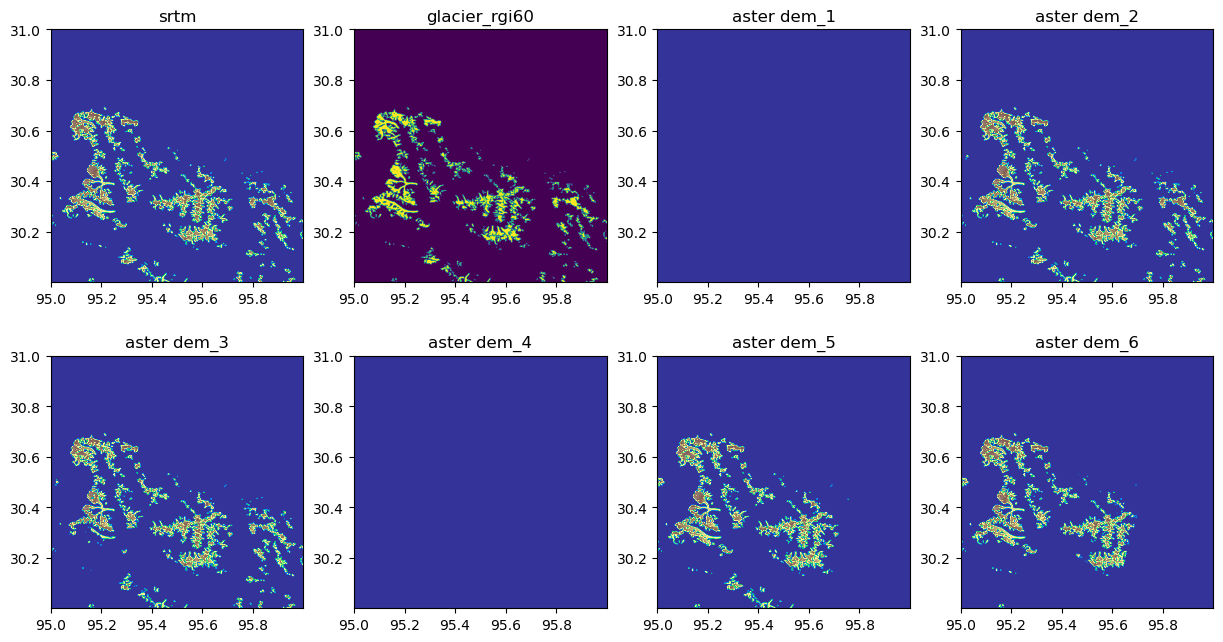

In [3]:
path_dems_laysta = 'dems_laysta.tif'
lay_stack(path_imgs=paths_img, path_out=path_dems_laysta, extent_mode='union', res=None)
dems_laysta, dems_info = readTiff(path_dems_laysta)
os.remove(path_dems_laysta)
num_dems = dems_laysta.shape[-1]-2
print('number of the dems: ', num_dems)
## Mask the nodata region and the non-glacier region.
glacier_mask_3d = np.dstack([dems_laysta[:,:,1:2]]*dems_laysta.shape[-1])
dems_laysta = np.ma.masked_where(np.logical_or(glacier_mask_3d == 0, dems_laysta == 0), dems_laysta) 
### check the layer stacked image. 
plt.figure(figsize=(15,12))
plt.subplot(3,4,1); plt.imshow(dems_laysta[:,:,0].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('srtm')
plt.subplot(3,4,2); plt.imshow(dems_laysta[:,:,1].filled(0), extent=dems_info['geoextent']); plt.title('glacier_rgi60')
plt.subplot(3,4,3); plt.imshow(dems_laysta[:,:,2].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_1')
plt.subplot(3,4,4); plt.imshow(dems_laysta[:,:,3].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_2')
plt.subplot(3,4,5); plt.imshow(dems_laysta[:,:,4].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_3')
plt.subplot(3,4,6); plt.imshow(dems_laysta[:,:,5].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_4')
plt.subplot(3,4,7); plt.imshow(dems_laysta[:,:,6].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_5')
plt.subplot(3,4,8); plt.imshow(dems_laysta[:,:,7].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_6')


### **2. Check the difference maps between aster dems and srtm.** 

In [4]:
### calculate dems difference map
dems_dif_map = np.zeros_like(dems_laysta.data[:,:,0:num_dems])
for i in range(num_dems):
  dems_dif_map[:,:,i] = dems_laysta[:,:,i+2]-dems_laysta[:,:,0]  # calculate dems diffference.
  dems_dif_map[:,:,i] = np.where(dems_laysta.mask[:,:,i+2] == True, -999, dems_dif_map[:,:,i])  ## mask the non-dem and non-glacier region.
dems_dif_map = np.ma.masked_where(np.logical_or(dems_dif_map==-999, abs(dems_dif_map)>150), dems_dif_map)
dems_dif_map.shape


(3600, 3600, 8)

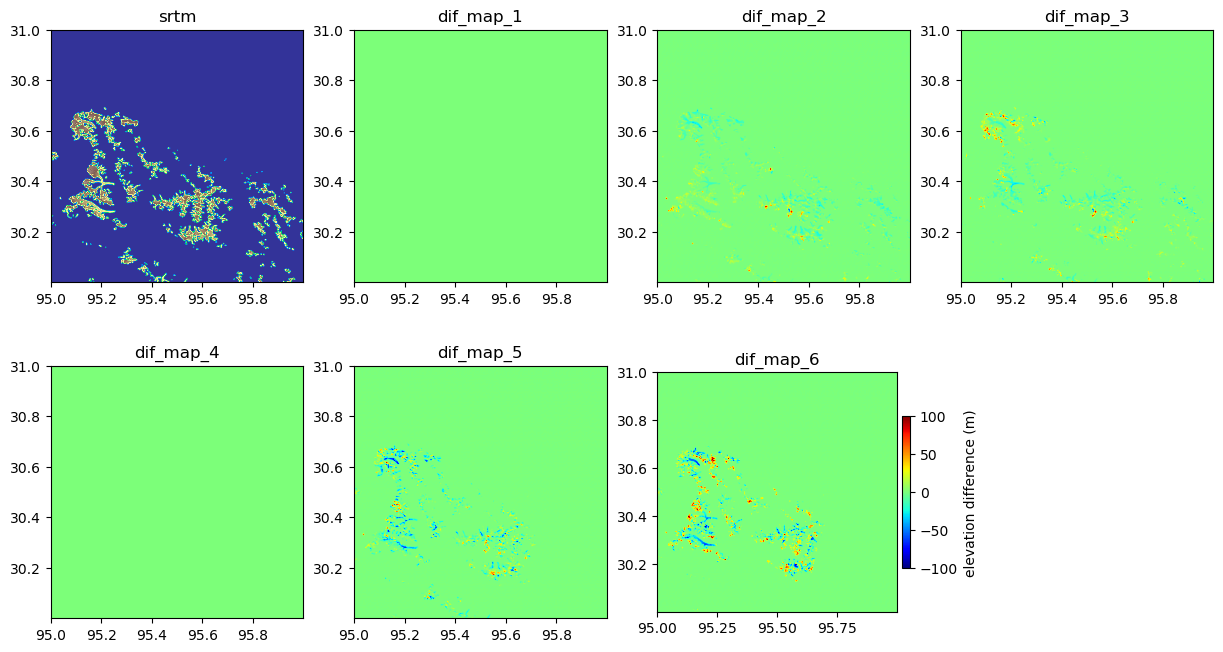

In [5]:
### check the dems difference map
plt.figure(figsize=(15,8))
plt.subplot(2,4,1); plt.imshow(dems_laysta[:,:,0].filled(0), vmax=7000, vmin=0, extent=dems_info['geoextent'], cmap='terrain');plt.title('srtm')
plt.subplot(2,4,2); plt.imshow(dems_dif_map[:,:,0].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_1')
plt.subplot(2,4,3); plt.imshow(dems_dif_map[:,:,1].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_2')
plt.subplot(2,4,4); plt.imshow(dems_dif_map[:,:,2].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_3')
plt.subplot(2,4,5); plt.imshow(dems_dif_map[:,:,3].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_4')
plt.subplot(2,4,6); plt.imshow(dems_dif_map[:,:,4].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_5')
plt.subplot(2,4,7); plt.imshow(dems_dif_map[:,:,5].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_6')
cb = plt.colorbar(fraction=0.03, pad=0.02)
cb.set_label('elevation difference (m)')


### **3. Filter out the outliers difference values in the tile.**
#### Outliers: lower than (mean - 3*sigma), or larger than (mean - 3*sigma).


In [6]:
dems_dif_map_filter = dems_dif_map.copy()
for i_dem in range(dems_dif_map.shape[-1]):
  num_valid = (~dems_dif_map_filter[:,:,i_dem].mask).sum()   ### number of the valid points
  print('Number of valid pixel: ', num_valid)
  if num_valid < 200:   ## mask out all values
    dems_dif_map_filter[:,:,i_dem] = np.ma.masked_all(dems_dif_map_filter[:,:,i_dem].shape)
  else:
    dif_mean, dif_sigma = np.mean(dems_dif_map_filter), np.std(dems_dif_map_filter)
    thre_max, thre_min = dif_mean + 3*dif_sigma, dif_mean - 3*dif_sigma
    dems_dif_map_filter[:,:,i_dem] = np.ma.masked_where(np.logical_or(dems_dif_map_filter[:,:,i_dem]>thre_max, \
                                          dems_dif_map_filter[:,:,i_dem]<thre_min), dems_dif_map_filter[:,:,i_dem])  
  num_filter = (~dems_dif_map_filter[:,:,i_dem].mask).sum()   ### number of the filtered points
  print('Number of filtered pixel: ', num_filter)
  if num_filter < 200:
    dems_dif_map_filter[:,:,i_dem] = np.ma.masked_all(dems_dif_map_filter[:,:,i_dem].shape)



Number of valid pixel:  0
Number of filtered pixel:  0
Number of valid pixel:  855459
Number of filtered pixel:  852083
Number of valid pixel:  754017
Number of filtered pixel:  747008
Number of valid pixel:  0
Number of filtered pixel:  0
Number of valid pixel:  718648
Number of filtered pixel:  705422
Number of valid pixel:  646002
Number of filtered pixel:  605765
Number of valid pixel:  681023
Number of filtered pixel:  643477
Number of valid pixel:  796821
Number of filtered pixel:  776608


#### **Check the filtered difference maps**

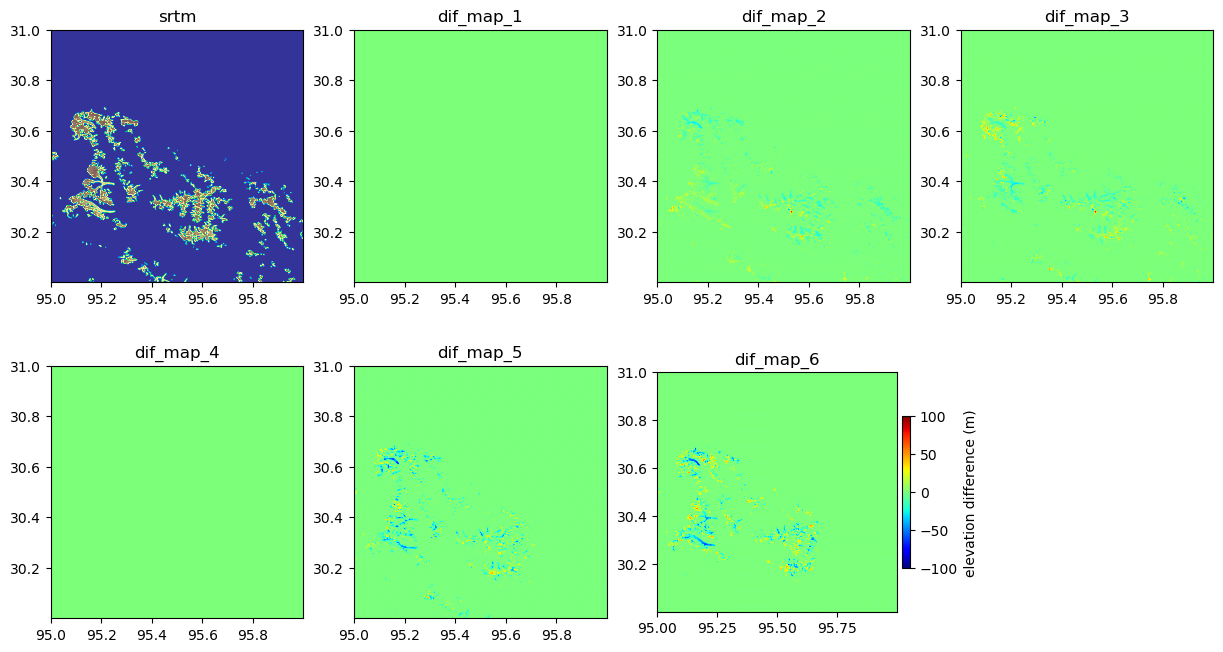

In [7]:
### check the filtered difference maps
plt.figure(figsize=(15,8))
plt.subplot(2,4,1); plt.imshow(dems_laysta[:,:,0].filled(0), vmax=7000, vmin=0, extent=dems_info['geoextent'], cmap='terrain');plt.title('srtm')
plt.subplot(2,4,2); plt.imshow(dems_dif_map_filter[:,:,0].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_1')
plt.subplot(2,4,3); plt.imshow(dems_dif_map_filter[:,:,1].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_2')
plt.subplot(2,4,4); plt.imshow(dems_dif_map_filter[:,:,2].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_3')
plt.subplot(2,4,5); plt.imshow(dems_dif_map_filter[:,:,3].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_4')
plt.subplot(2,4,6); plt.imshow(dems_dif_map_filter[:,:,4].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_5')
plt.subplot(2,4,7); plt.imshow(dems_dif_map_filter[:,:,5].filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_6')
cb = plt.colorbar(fraction=0.03, pad=0.02)
cb.set_label('elevation difference (m)')



### **4.Calculate the average value and standard deviation of the elevation difference.**


In [8]:
for i_dem in range(dems_dif_map_filter.shape[-1]):
    print('mean:', np.mean(dems_dif_map_filter[:,:,i_dem]), ' sigma: ', np.std(dems_dif_map_filter[:,:,i_dem]))


mean: --  sigma:  --
mean: -1.6240912618694423  sigma:  16.657762518637757
mean: -0.8005006262666154  sigma:  20.89536803468846
mean: --  sigma:  --
mean: -7.141815702867286  sigma:  29.111952064533998
mean: -3.210043071506174  sigma:  36.57601911145489
mean: -6.3058566642782345  sigma:  29.81567505394745
mean: -11.889844771884292  sigma:  24.546233633848292


#### Statistic of the elevation difference values and plot the histogram.


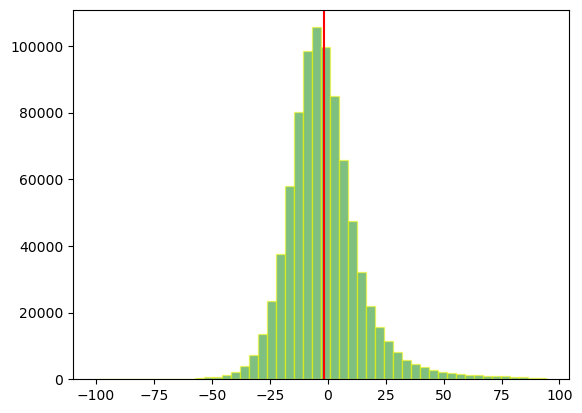

In [9]:
i_dem = 1
id_valid = np.where(dems_dif_map_filter[:,:,i_dem].mask == False)
n, bins, patches = plt.hist(dems_dif_map_filter[:,:,i_dem][id_valid], \
                                    bins=50, lw=1, ec="yellow", fc="green", alpha=0.5)
plt.axvline(x = np.mean(dems_dif_map_filter[:,:,i_dem]), color = 'r', label = 'axvline - full height')
